# University of Wisconsin-Madison - School of Business

Neda Jabbari, Erica Ho, Juan Julian Herranz
08/08/2019



Data reterived from:
Browse through the information page for the University of Wisconsin Madison 
https://www.kaggle.com/Madgrades/uw-madison-courses


Idenfify the courses related to the school of business.
Business courses code ref: https://bus.wisc.edu/current-student-resources/bba/study-abroad/incoming-exchange-students/courses 

## H1: Course instructors affect the ratio of A grades.
## H0: Course instructors have no effect on the ratio of A grades.

In [257]:
import pandas as pd
import numpy as np
import psycopg2
import statsmodels.api as sm
from statsmodels.formula.api import ols
import scipy.stats as s
from scipy.stats import ttest_ind
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [230]:
conn = psycopg2.connect(host='localhost',
                        database='uw-madison-courses')
cur = conn.cursor()

To investigate a relationship between course instructors and grades in the school of business, obtain data from: course_offerings, grade_distribution, subject_memberships, sections, teachings

In [205]:
bus_courses = ['231', '232', '233', '235', '236', '237', '238', '239', '241', '242']

Querry the database to retrieve information on the desired courses.

In [209]:
cur.execute("""SELECT DISTINCT ON (s.course_offering_uuid, s.number)
                      co.uuid
                      ,co.name
                      ,gd.section_number
                      , gd.a_count
                      , gd.ab_count
                      , gd.b_count
                      , gd.bc_count
                      ,gd.c_count
                      , gd.d_count
                      , gd.f_count
                      ,s.uuid
                      ,t.instructor_id
               FROM course_offerings co
               INNER JOIN grade_distributions gd on co.uuid=gd.course_offering_uuid
               INNER JOIN subject_memberships sm on co.uuid=sm.course_offering_uuid
               INNER JOIN sections s ON co.uuid=s.course_offering_uuid
               INNER JOIN teachings t ON s.uuid=t.section_uuid
               WHERE sm.subject_code in ('231', '232', '233', '235', '236', '237', '238', '239', '241', '242')
               ;""")

business_courses = pd.DataFrame(cur.fetchall())
business_courses.columns = ['uuid', 'name', 'section_number', 'a_count',
                            'ab_count', 'b_count', 'bc_count', 'c_count', 'd_count', 'f_count', 'section_uuid', 'instructor_id']
business_courses.head(5)

,uuid,name,section_number,a_count,ab_count,b_count,bc_count,c_count,d_count,f_count,section_uuid,instructor_id
0,00128b0a-ffbf-332c-b93c-53e011e55fb5,Reading & Rsch-Finance PhD,16,0,0,0,0,0,0,0,f03eb2e1-8010-3357-97ce-6fa2e3c87499,4461496
1,0015c914-93c4-3991-a63f-ea8a6e208552,Contemporary Topics,1,15,8,3,0,0,0,0,75c792a0-42cd-37f6-a575-37fb25644168,473200
2,0015c914-93c4-3991-a63f-ea8a6e208552,Contemporary Topics,1,15,8,3,0,0,0,0,46fdf222-bd05-393d-bcd8-fb7c16dc0c76,260106
3,00293eb5-6dc1-36f7-99fc-6d8fb17f37d9,Readng & Rsch-Marketing PhD,107,0,0,0,0,0,0,0,deeb10e2-4a84-3f2a-aa82-c060327abf3b,4461492
4,00293eb5-6dc1-36f7-99fc-6d8fb17f37d9,Readng & Rsch-Marketing PhD,107,0,0,0,0,0,0,0,e3a71e45-d934-3a90-ace3-1c3623724667,3039911


In [210]:
sum(business_courses.duplicated())

0

In [186]:
cur.execute("""SELECT DISTINCT co1.uuid,
                      count(distinct t.instructor_id) as teachers
               FROM course_offerings co1
               INNER JOIN subject_memberships sm on co1.uuid=sm.course_offering_uuid
               INNER JOIN sections s ON co1.uuid=s.course_offering_uuid
               INNER JOIN teachings t ON s.uuid=t.section_uuid
               WHERE sm.subject_code in ('231', '232', '233', '235', '236', '237', '238', '239', '241', '242')
               GROUP BY co1.uuid, sm.subject_code
               ORDER BY teachers DESC
               ;""")

b_c_tchr_df = pd.DataFrame(cur.fetchall())
b_c_tchr_df.columns = [i[0] for i in cur.description]
b_c_tchr_df.head()

,uuid,teachers
0,152af4c6-2068-30b2-b65c-1f61d4d5c869,29
1,030862be-dbe8-375b-9691-778b53a1963f,22
2,1fbb001b-7a3f-3759-aca8-028ce3beb2f9,22
3,5b47862c-613e-3bc6-9412-db16cc5e2cb5,22
4,9ba4f0e1-7138-3c05-8a34-36b39adde3fc,22


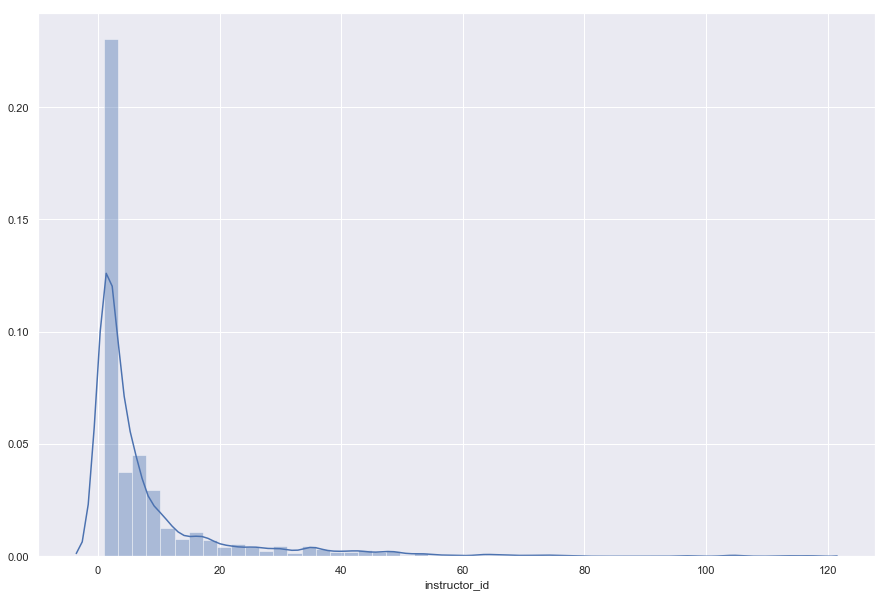

In [211]:
sns.set(rc={'figure.figsize':(15,10)})
sns.distplot(business_courses['instructor_id'].value_counts());

In [212]:
business_courses.instructor_id.nunique()

1180

### Data engineering to include the total number of students in order to generate the As ratio

Given that the grade columns are all strings, we need to convert them into integers in order to manipulate them

In [213]:
grade_cols = ['a_count', 'ab_count', 'b_count', 'bc_count', 'c_count', 'd_count', 'f_count']

for grade_col in grade_cols:
    business_courses[grade_col] = business_courses[grade_col].apply(lambda x: int(x))

In [214]:
business_courses['n_students'] = (business_courses['a_count'] + business_courses['ab_count'] 
                                         + business_courses['b_count'] + business_courses['bc_count']
                                         + business_courses['c_count'] + business_courses['d_count']
                                         + business_courses['f_count'])

In [215]:
business_courses.head(2)
business_courses.shape

(9858, 13)

In [216]:
business_courses = business_courses[business_courses['n_students']!= 0]

In [228]:
business_courses.shape

(8403, 14)

In [220]:
business_courses['ratio_of_a_grades'] = business_courses['a_count'] / business_courses['n_students']

### Performing ANOVA test

In [222]:
formula = 'ratio_of_a_grades ~ instructor_id'
lm = ols(formula, business_courses).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                   sum_sq      df         F  PR(>F)
instructor_id  347.855658  1162.0  9.184688     0.0
Residual       235.975591  7240.0       NaN     NaN


ANOVA test suggests that Course instructors affect the ratio of A grades.

## H1: The average grade among students who take online courses is lower than the rest of the students.
## H0: The average grade among students who take online courses is not different from other students.



In [240]:
query = """
SELECT DISTINCT ON (sections.course_offering_uuid, sections.number)
  sections.uuid
, sections.course_offering_uuid
, sections.section_type
, sections.number AS section_number
, sections.room_uuid
, sections.schedule_uuid
-- , course_offering_uuid
-- , section_number
, n_count
, c_count
, f_count
, cr_count
, p_count
, nw_count
, other_count
, bc_count
, u_count
, d_count
, ab_count
, a_count
, s_count
, i_count
, b_count
, nr_count
-- , uuid
, facility_code
, room_code
,course_offerings.name
-- ,subject_code
FROM sections 
    INNER JOIN grade_distributions
        ON sections.course_offering_uuid = grade_distributions.course_offering_uuid
            AND sections.number = grade_distributions.section_number
    INNER JOIN course_offerings 
        ON sections.course_offering_uuid = course_offerings.uuid
    INNER JOIN subject_memberships
        ON sections.course_offering_uuid = subject_memberships.course_offering_uuid
    LEFT JOIN rooms ON sections.room_uuid = rooms.uuid
    WHERE subject_memberships.subject_code in ('231', '232', '233', '235', '236', '237', '238', '239', '241', '242')


;                      
"""

cur.execute(query)
df= pd.DataFrame(cur.fetchall())
df.columns = [i[0] for i in cur.description]
df.head(5)

,uuid,course_offering_uuid,section_type,section_number,room_uuid,schedule_uuid,n_count,c_count,f_count,cr_count,...,d_count,ab_count,a_count,s_count,i_count,b_count,nr_count,facility_code,room_code,name
0,f03eb2e1-8010-3357-97ce-6fa2e3c87499,00128b0a-ffbf-332c-b93c-53e011e55fb5,IND,16,null,f2d66a4d-0c08-3b48-abf6-649fffd7ae90,0,0,0,0,...,0,0,0,0,0,0,0,None,None,Reading & Rsch-Finance PhD
1,75c792a0-42cd-37f6-a575-37fb25644168,0015c914-93c4-3991-a63f-ea8a6e208552,LEC,1,bb9eba97-b269-3860-b60e-804c98a90461,488512b0-55c4-37eb-8ef3-f6c2edb595c9,0,0,0,0,...,0,8,15,1,0,3,0,0140,2195,Contemporary Topics
2,46fdf222-bd05-393d-bcd8-fb7c16dc0c76,0015c914-93c4-3991-a63f-ea8a6e208552,LEC,7,dd6118e0-7221-3b81-9b29-aad61f0ede54,acfa659f-afaa-355c-a3a9-16d23ad183b9,0,0,0,0,...,0,0,18,0,0,0,0,0140,1070,Contemporary Topics
3,deeb10e2-4a84-3f2a-aa82-c060327abf3b,00293eb5-6dc1-36f7-99fc-6d8fb17f37d9,IND,10,null,f2d66a4d-0c08-3b48-abf6-649fffd7ae90,0,0,0,0,...,0,0,0,0,0,0,0,None,None,Readng & Rsch-Marketing PhD
4,e3a71e45-d934-3a90-ace3-1c3623724667,00293eb5-6dc1-36f7-99fc-6d8fb17f37d9,IND,107,null,f2d66a4d-0c08-3b48-abf6-649fffd7ae90,0,0,0,0,...,0,0,0,0,0,0,0,None,None,Readng & Rsch-Marketing PhD


In [241]:
sum(df.duplicated())   #no duplicated rows

0

In [242]:
df = df.drop(
    ['course_offering_uuid','section_number','schedule_uuid','n_count','cr_count',
     'p_count','nw_count','other_count','u_count','s_count','i_count','nr_count'], axis=1)

In [243]:
for i in list(df.columns[3:10]):df[i]=df[i].astype('int64')   #convert str grade counts to int

In [244]:
count_cols = sorted(i for i in df.columns if i.endswith('_count'))

grade_points = [4.0, 3.5, 3.0, 2.5, 2.0, 1.0, 0.0]

count_col_values = dict(zip(count_cols, grade_points))
count_col_values

{'a_count': 4.0,
 'ab_count': 3.5,
 'b_count': 3.0,
 'bc_count': 2.5,
 'c_count': 2.0,
 'd_count': 1.0,
 'f_count': 0.0}

In [245]:
grades_df = df.loc[:, count_col_values.keys()]

In [246]:
grade_values = np.array(list(count_col_values.values()))

In [247]:
grade_counts = grades_df.values
grade_counts[1]
sum(grade_counts[1])

26

In [248]:
grade_points = grade_counts @ grade_values

In [249]:
df['avg_grade_points'] = [grade_points[i]/sum(grade_counts[i]) 
                                                for i in range(len(grade_points))]

/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


In [250]:
df = df.dropna(subset = ['avg_grade_points'])

In [251]:
df.loc[df['facility_code']=='ONLINE']['room_uuid'].unique()    #the room unique id for online courses is 86d1debf-3f3a-39b7-bc0d-976a4fa33862

array(['86d1debf-3f3a-39b7-bc0d-976a4fa33862'], dtype=object)

In [252]:
#to get the list of online courses 
online_df = df.loc[df['room_uuid']=='86d1debf-3f3a-39b7-bc0d-976a4fa33862']
online_df.head()
online_df.shape

(53, 14)

In [253]:
#to get the list of courses that are not online
non_online_df = df.loc[df['room_uuid']!='86d1debf-3f3a-39b7-bc0d-976a4fa33862']
non_online_df.head()
non_online_df.shape

(5655, 14)

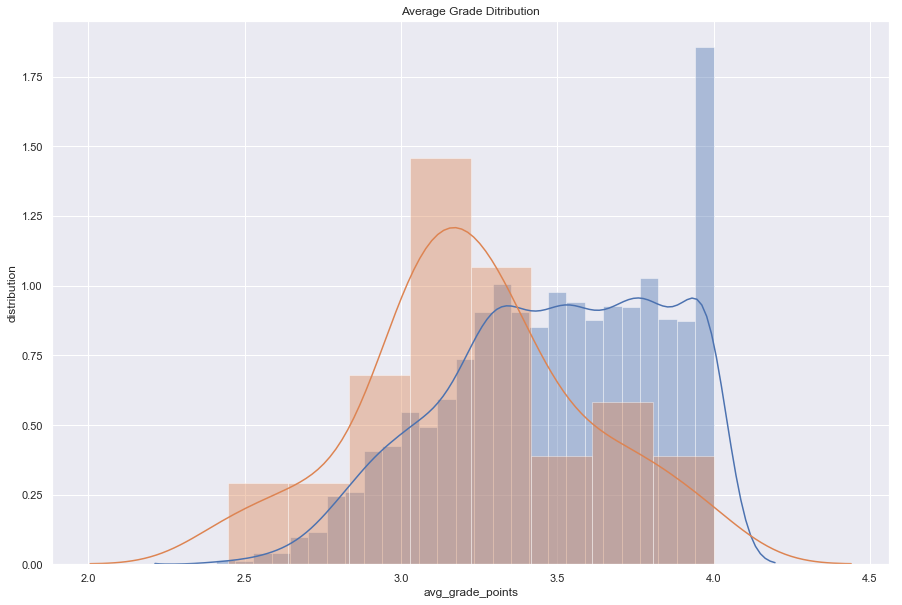

In [255]:
sns.set(rc={'figure.figsize':(15,10)})
plt.ylabel('distribution')
plt.title('Average Grade Ditribution')
sns.distplot(non_online_df['avg_grade_points']);  # Blue distribution
sns.distplot(online_df['avg_grade_points']);  # Orange distribution

In [258]:
print(s.normaltest(non_online_df['avg_grade_points']))  #non_online avg grade points are not normally distributed
print(s.normaltest(online_df['avg_grade_points']))     #online avg grade points are not normally distributed

NormaltestResult(statistic=396.16127992319343, pvalue=9.433461749270088e-87)
NormaltestResult(statistic=0.13421102167083698, pvalue=0.9350965333151684)


In [259]:
non_online_sample_means= [non_online_df['avg_grade_points'].sample(frac = 1, replace = True).mean() 
                          for i in range(1000)]

In [260]:
online_sample_means= [online_df['avg_grade_points'].sample(frac = 1, replace = True).mean() 
                          for i in range(1000)]

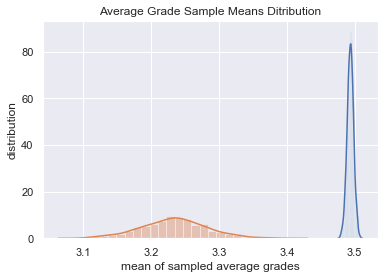

In [262]:
plt.xlabel('mean of sampled average grades')
plt.ylabel('distribution')
plt.title('Average Grade Sample Means Ditribution')
sns.distplot(non_online_sample_means);
sns.distplot(online_sample_means);

In [263]:
ttest_ind(non_online_sample_means, online_sample_means)  

Ttest_indResult(statistic=171.1653925254367, pvalue=0.0)

With alpha of 0.05 and pvalue/2 < alpha, the average grade among students who take online courses is lower than the rest of the students.

## H1: There is a difference between lecture classes of different number of students in terms of average grades.
## H0: There is no difference between lecture classes of different number of students in terms of average grades.

In [286]:
non_online_lecture_df= non_online_df[non_online_df["section_type"]=='LEC']

In [287]:
count_cols = sorted(i for i in df.columns if i.endswith('_count'))

In [289]:
non_online_lecture_df['class_size'] = non_online_lecture_df.loc[:, count_cols].sum(axis=1)

/Users/flatironschool/anaconda3/envs/learn/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


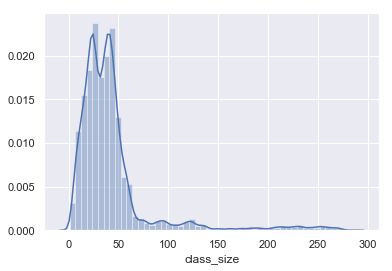

In [290]:
sns.distplot(non_online_lecture_df['class_size']);  # Blue distribution

In [291]:
mean_class_size = non_online_lecture_df['class_size'].mean() 

In [292]:
below_mean_non_online_lecture_df = non_online_lecture_df.loc[non_online_lecture_df['class_size'] > 
                                                             mean_class_size]
above_mean_non_online_lecture_df = non_online_lecture_df.loc[non_online_lecture_df['class_size'] < 
                                                             mean_class_size]

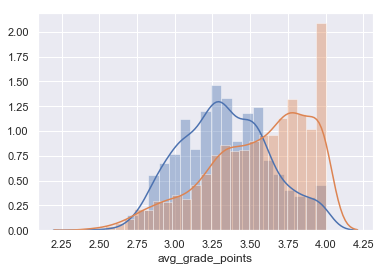

In [293]:
sns.distplot(below_mean_non_online_lecture_df['avg_grade_points']);  # Blue distribution
sns.distplot(above_mean_non_online_lecture_df['avg_grade_points']);

In [294]:
#check if the data is normally distributed
print(s.normaltest(below_mean_non_online_lecture_df['avg_grade_points'])) 

print(s.normaltest(above_mean_non_online_lecture_df['avg_grade_points']))

NormaltestResult(statistic=33.975159787286486, pvalue=4.1916768230513746e-08)
NormaltestResult(statistic=255.83459375200118, pvalue=2.793983433951491e-56)


In [295]:
below_mean_non_online_lecture_sample_means= [below_mean_non_online_lecture_df['avg_grade_points'].sample(frac = 1, replace = True).mean() 
                          for i in range(1000)]

In [296]:
above_mean_non_online_lecture_sample_means= [above_mean_non_online_lecture_df['avg_grade_points'].sample(frac = 1, replace = True).mean() 
                          for i in range(1000)]

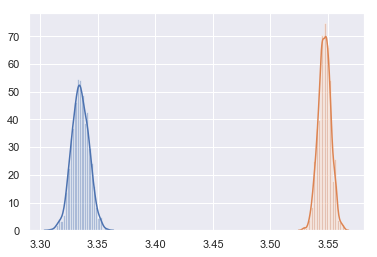

In [297]:
sns.distplot(below_mean_non_online_lecture_sample_means);
sns.distplot(above_mean_non_online_lecture_sample_means);

In [298]:
ttest_ind(below_mean_non_online_lecture_sample_means, above_mean_non_online_lecture_sample_means)  

Ttest_indResult(statistic=-727.7911019177567, pvalue=0.0)

Based on the P-value and the alpha of 0.05, there is a difference between lecture classes of different number of students in terms of average grades.

## H1: There is a difference between grades offered in Fall term and those in Spring term.
## H0: There is no difference between grades offered in Fall term and those in Spring term.

In [265]:
cur.execute ( """SELECT
DISTINCT ON (sections.course_offering_uuid, sections.number)
  sections.uuid
, sections.course_offering_uuid
, sections.section_type
, sections.number AS section_number
, sections.schedule_uuid
, facility_code
, term_code
, course_offerings.name
, a_count
, ab_count
, b_count
, bc_count
, c_count
, d_count
, f_count
-- ,subject_code
-- , course_offering_uuid
-- , section_number
-- , uuid
FROM sections
   INNER JOIN grade_distributions
       ON sections.course_offering_uuid = grade_distributions.course_offering_uuid
           AND sections.number = grade_distributions.section_number
   INNER JOIN course_offerings
       ON sections.course_offering_uuid = course_offerings.uuid
   INNER JOIN subject_memberships
       ON sections.course_offering_uuid = subject_memberships.course_offering_uuid
   LEFT JOIN rooms ON sections.room_uuid = rooms.uuid
WHERE subject_memberships.subject_code in ('232', '233', '231', '237', '238', '242', '236', '239', '235','241')
;""")
course_grades_sub_df= pd.DataFrame(cur.fetchall())
course_grades_sub_df.columns = [i[0] for i in cur.description]

In [266]:
course_grades_sub_df['c_count'] = course_grades_sub_df['c_count'].astype(int)
course_grades_sub_df['bc_count'] = course_grades_sub_df['bc_count'].astype(int)
course_grades_sub_df['d_count'] = course_grades_sub_df['d_count'].astype(int)
course_grades_sub_df['ab_count'] = course_grades_sub_df['ab_count'].astype(int)
course_grades_sub_df['a_count'] = course_grades_sub_df['a_count'].astype(int)
course_grades_sub_df['b_count'] = course_grades_sub_df['b_count'].astype(int)
course_grades_sub_df['f_count'] = course_grades_sub_df['f_count'].astype(int)

In [267]:
course_grades_sub_df['total_num_student'] = (course_grades_sub_df['a_count'] 
                                             + course_grades_sub_df['ab_count'] 
                                             + course_grades_sub_df['b_count']
                                             + course_grades_sub_df['bc_count'] 
                                             + course_grades_sub_df['c_count'] 
                                             + course_grades_sub_df['d_count'] 
                                             + course_grades_sub_df['f_count'])

In [268]:
course_grades_sub_df['avg_grade'] = (course_grades_sub_df['a_count']*4 + course_grades_sub_df['ab_count']*3.5 
+ course_grades_sub_df['b_count']*3 + course_grades_sub_df['bc_count']*2.5 + course_grades_sub_df['c_count']*2
+ course_grades_sub_df['d_count']*1)/course_grades_sub_df['total_num_student']

As the analysis is solely based on courses that are graded, the dataframe only includes classes that have grades 

In [269]:
course_grades_sub_df = course_grades_sub_df.loc[~(course_grades_sub_df['total_num_student']==0),:]

In [270]:
course_grades_sub_df['term_code'] = course_grades_sub_df['term_code'].astype(str)

In [271]:
def term(term_code):
    if term_code[-1] == '2':
        return 'fall'
    elif term_code[-1] == '4':
        return 'spring'
    else:
        return 'other'           
        
course_grades_sub_df['term'] = course_grades_sub_df['term_code'].apply(term)

In [272]:
other_df = course_grades_sub_df.loc[course_grades_sub_df['term'] == 'other']
len(other_df)

0

In [273]:
fall_df = course_grades_sub_df.loc[course_grades_sub_df['term'] == 'fall']
len(fall_df)

3168

In [274]:
spring_df = course_grades_sub_df.loc[course_grades_sub_df['term'] == 'spring']
len(spring_df)

2540

Fall term dataframe

In [275]:
fall_sample_mean = sum(fall_df['avg_grade'])/len(fall_df)

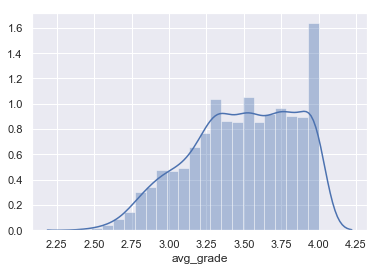

In [276]:
sns.distplot(fall_df['avg_grade'])

Spring term dataframe

In [277]:
spring_sample_mean = sum(spring_df['avg_grade'])/len(spring_df)

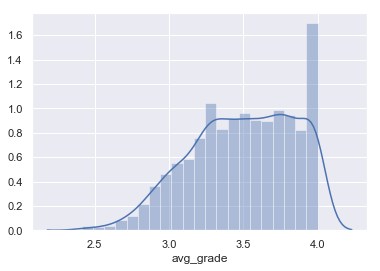

In [278]:
sns.distplot(spring_df['avg_grade'])

Bootstrapping for fall term and spring term

In [279]:
bootstrap_samples_fall = []
bootstrap_sample_means_fall = np.zeros(3168)
for i in range(3168):
    bootstrap_sample = np.random.choice(fall_df['avg_grade'], size=3168)
    bootstrap_samples_fall.append(bootstrap_sample)
    bootstrap_sample_means_fall[i] = bootstrap_sample.mean()

In [280]:
bootstrap_samples_spring = []
bootstrap_sample_means_spring = np.zeros(2540)
for i in range(2540):
    bootstrap_sample = np.random.choice(spring_df['avg_grade'], size=2540)
    bootstrap_samples_spring.append(bootstrap_sample)
    bootstrap_sample_means_spring[i] = bootstrap_sample.mean()

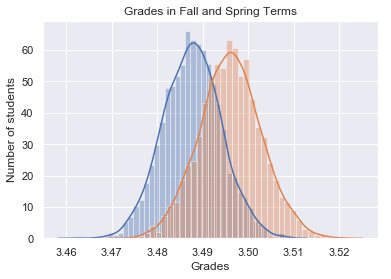

In [281]:
fig, ax = plt.subplots()
sns.distplot(bootstrap_sample_means_fall)
sns.distplot(bootstrap_sample_means_spring)
plt.title('Grades in Fall and Spring Terms')
plt.xlabel('Grades')
plt.ylabel('Number of students');

In [284]:
print(s.ttest_ind(spring_df['avg_grade'], fall_df['avg_grade']))

Ttest_indResult(statistic=0.9279896603589155, pvalue=0.35345218478355545)


Based on the P-value and the alpha of 0.05, there is no difference between grades offered in Fall term and those in Spring term